In [1]:
pip install catboost

     |████████████████████████████████| 67.4 MB 27 kB/s 


In [2]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,make_scorer,precision_score,recall_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier


In [71]:
df = pd.read_csv('https://raw.githubusercontent.com/joshuasir/ml-project/main/datasets-stock-exchange/stock-market-train-clean.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/joshuasir/ml-project/main/datasets-stock-exchange/stock-market-test-clean.csv')

In [13]:
df.head()

,SMA,EMA,WMA,RSI,MOM,STC,CCI,Target,MACD,SIG
0,4900.000476,5020.087951,5010.418001,51.429758,-151.020019,5.053916e+01,-2.245385,1,31.471910,54.847689
1,10413.451245,10681.954822,10707.140105,58.814760,115.250000,1.000000e+02,106.378001,1,93.761021,88.574211
2,16275.027963,15939.891071,15896.112086,36.704528,-544.620120,2.368476e-14,-111.855154,1,-187.684112,-123.642882
3,2083.788521,2001.285467,1989.849091,25.730361,-96.630005,0.000000e+00,-128.284676,0,-35.048194,-25.875564
4,1026.667558,1046.315897,1050.611778,54.826030,28.849975,9.831526e+01,53.778929,0,9.237960,8.281168


In [72]:
X = df.copy()
y = X.pop('Target')
X_valid = df_test.copy()
y_valid = X_valid.pop('Target')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=42)

In [15]:
y.value_counts()

0    42530
1    29698
Name: Target, dtype: int64

we will be using cross validation and precision as our metric since our data is unbalance

## Baseline Model

In [16]:
model = DummyClassifier(strategy='stratified')


scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
    }


scores = cross_validate(model, X_train, y_train,
                              cv=5,
                              scoring=scoring)

print("Precision scores:\n", scores['test_Precision'].mean())
print("Recall scores:\n", scores['test_Recall'].mean())
print("F1 scores:\n", scores['test_F1'].mean())

# print('Dummy Classifier :', model.score(y_test,pred))
# print(classification_report(y_test,pred))

Precision scores:
 0.499454836383893
Recall scores:
 0.49945866570447073
F1 scores:
 0.4994527517069871


## Comparing Model

In [17]:

def train(classifier,name='',graph=False):
    
    scoring = {
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
           'ROC_AUC'  : 'roc_auc'
    }
    score_dict = cross_validate(classifier, X_train, y_train,
                              cv=10,
                              scoring=scoring)
    
    scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
    scores = scores.append(pd.Series({ 
                                      'Model' : name,
                                      # 'Accuracy' : score_dict['test_Accuracy'].mean(),
                                      'Precision' : score_dict['test_Precision'].mean(),
                                      'Recall' : score_dict['test_Recall'].mean(),
                                      'F1' : score_dict['test_F1'].mean(),
                                      'ROC AUC' : score_dict['test_ROC_AUC'].mean()
    }),ignore_index=True)
 
    return scores

In [18]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer


models =  { "Decision Tree" : DecisionTreeClassifier(),
            "Random Forest" : RandomForestClassifier(),
            "XGBoost" : XGBClassifier(), 
            "LogisticRegression" : LogisticRegression(max_iter=1200), 
            "CatBoost" :CatBoostClassifier(verbose=False) ,
            'LGBM' : LGBMClassifier(),
            'KNeighbors' : KNeighborsClassifier(),
            'AdaBoost' : AdaBoostClassifier()
            }

scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
# probability = {}

for model in models:
  scores = scores.append(train(models[model],name=model))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [19]:
scores.sort_values('Precision',ascending=False).reset_index(drop=True)

,Model,Precision,Recall,F1,ROC AUC
0,CatBoost,0.749528,0.738343,0.741983,0.835827
1,LGBM,0.743557,0.731782,0.735476,0.828733
2,Random Forest,0.731098,0.719671,0.723153,0.812777
3,XGBoost,0.714079,0.690940,0.694863,0.788156
4,AdaBoost,0.700453,0.684055,0.687393,0.771144
5,Decision Tree,0.653306,0.653140,0.653208,0.653140
6,LogisticRegression,0.630016,0.582280,0.565447,0.672487
7,KNeighbors,0.591965,0.588349,0.588940,0.638127


CatBoost seems to be the best model here

In [20]:
cross_validate(CatBoostClassifier(verbose=False), X_train, y_train, cv=10, scoring='precision_macro')['test_score'].mean()

0.7495280870999379

## Model Tuning and Train

In [ ]:

param_grid = {
    'depth':[7,8,5],
    'learning_rate':[.1,.05],
    'iterations':[800,900,700],
    'l2_leaf_reg':[9,5]
}

grid = GridSearchCV(estimator=CatBoostClassifier(),param_grid = param_grid,cv=5)
grid.fit(X_train,y_train)


In [26]:
grid.best_params_

{'depth': 8, 'iterations': 800, 'l2_leaf_reg': 9, 'learning_rate': 0.1}

In [27]:
model = CatBoostClassifier(depth=8,iterations=800,l2_leaf_reg=9,learning_rate=.1,verbose=False)
history = model.fit(X_train,y_train)
pred = model.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81     12759
           1       0.74      0.66      0.70      8910

    accuracy                           0.76     21669
   macro avg       0.76      0.75      0.75     21669
weighted avg       0.76      0.76      0.76     21669



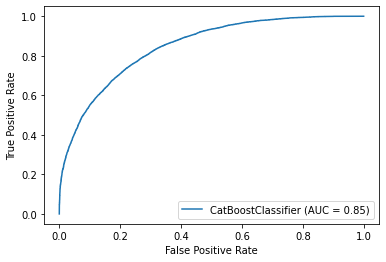

In [28]:
from sklearn import metrics

metrics.plot_roc_curve(model, X_test, y_test)

let's move the threshold to get a better result

In [66]:
def evaluation(model,X,y,threshold=.44):
  score = model.predict_proba(X)[:, 1]
  result = [(i > threshold) for i in score]
  print(classification_report(y, result, labels=[0,1]))
  print('Precision avg :', precision_score(y,result,average='weighted'))
  print('Recall avg :', recall_score(y,result,average='weighted'))

In [67]:
evaluation(model,X_test,y_test)

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     12759
           1       0.70      0.74      0.72      8910

    accuracy                           0.76     21669
   macro avg       0.76      0.76      0.76     21669
weighted avg       0.77      0.76      0.76     21669

Precision avg : 0.7650115906094975
Recall avg : 0.7629793714523051


In [37]:
pip install shap

     |████████████████████████████████| 356 kB 8.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491645 sha256=2c556a22a1c3d9566501e1cd0d5dd8c1db205e648784ba9794816d85ba82772d
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


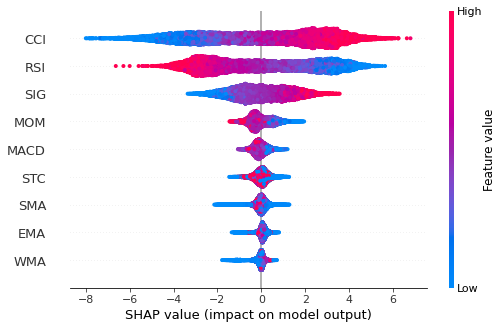

In [38]:
import shap  

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test)

In [45]:
X_train_clean = X_train.drop(columns=['WMA'])
X_test_clean = X_test.drop(columns=['WMA'])

In [46]:
model = CatBoostClassifier(depth=8,iterations=800,l2_leaf_reg=9,learning_rate=.1,verbose=False)
history = model.fit(X_train_clean,y_train)
pred = model.predict(X_test_clean)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     12759
           1       0.74      0.67      0.70      8910

    accuracy                           0.77     21669
   macro avg       0.76      0.75      0.76     21669
weighted avg       0.77      0.77      0.76     21669



There aren't any much difference from the original X_test's report so we will just use the old one

## Evaluation on Unseen Values

In [73]:
evaluation(model,X_valid,y_valid)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     18228
           1       0.70      0.73      0.71     12728

    accuracy                           0.76     30956
   macro avg       0.75      0.75      0.75     30956
weighted avg       0.76      0.76      0.76     30956

Precision avg : 0.760614471824147
Recall avg : 0.7583344101305078


We get the final result of about 76% where we focus more on the precision of each class.